In [1]:
from google.colab import files
uploaded = files.upload()


Saving week_approach_maskedID_timeseries.csv to week_approach_maskedID_timeseries.csv


We drop the attributes we know are not useful based on empirical data. 

In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn as sk
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score 
import io


df = pd.read_csv(io.StringIO(uploaded['week_approach_maskedID_timeseries.csv'].decode('utf-8')))
df = df.drop(['avg training success', 'min training success', 'max training success', 'avg training success.1', 'max training success.1', 'min training success.1'], axis = 1)
df = df.drop(['avg training success.2', 'max training success.2', 'min training success.2', 'avg exertion', 'min exertion', 'max exertion'], axis = 1)
df = df.drop(['avg exertion.1', 'min exertion.1', 'max exertion.1', 'avg exertion.2', 'min exertion.2', 'max exertion.2', 'max km one day'], axis = 1)
df = df.drop(['avg recovery', 'min recovery', 'max recovery', 'avg recovery.1', 'min recovery.1', 'max recovery.1', 'avg recovery.2', 'min recovery.2', 'max recovery.2'], axis = 1)
df = df.drop(['rel total kms week 0_1', 'rel total kms week 0_2', 'rel total kms week 1_2'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42798 entries, 0 to 42797
Data columns (total 41 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   nr. sessions                                   42798 non-null  float64
 1   nr. rest days                                  42798 non-null  float64
 2   total kms                                      42798 non-null  float64
 3   total km Z3-Z4-Z5-T1-T2                        42798 non-null  float64
 4   nr. tough sessions (effort in Z5, T1 or T2)    42798 non-null  float64
 5   nr. days with interval session                 42798 non-null  float64
 6   total km Z3-4                                  42798 non-null  float64
 7   max km Z3-4 one day                            42798 non-null  float64
 8   total km Z5-T1-T2                              42798 non-null  float64
 9   max km Z5-T1-T2 one day                        427

In [5]:
df0 = df[df['Athlete ID'] == 3]
y = 42238 - len(df0[df0['injury']==0]) - len(df0[df0['injury']==1])
index1 = df0.index[0]
indexLast = df0.index[-1]
df0 = df0.rename(index = lambda x: x - y - 1 if x > indexLast - len(df0[df0['injury']==1]) else x - index1)
df0 = df0.sort_values(by = 'Date')
df0

,nr. sessions,nr. rest days,total kms,total km Z3-Z4-Z5-T1-T2,"nr. tough sessions (effort in Z5, T1 or T2)",nr. days with interval session,total km Z3-4,max km Z3-4 one day,total km Z5-T1-T2,max km Z5-T1-T2 one day,...,nr. days with interval session.2,total km Z3-4.2,max km Z3-4 one day.2,total km Z5-T1-T2.2,max km Z5-T1-T2 one day.2,total hours alternative training.2,nr. strength trainings.2,Athlete ID,injury,Date
0,7.0,1.0,67.4,17.1,4.0,4.0,0.0,0.0,14.7,10.0,...,2.0,3.5,3.5,0.6,0.6,0.0,0.0,3,0,0
1,7.0,1.0,66.9,16.6,4.0,4.0,0.0,0.0,15.5,10.0,...,3.0,3.5,3.5,1.3,0.7,0.0,0.0,3,0,1
2,7.0,1.0,67.7,15.9,4.0,4.0,0.0,0.0,14.8,10.0,...,3.0,3.5,3.5,1.3,0.7,0.0,0.0,3,0,2
3,7.0,1.0,68.7,15.9,4.0,4.0,0.0,0.0,14.8,10.0,...,4.0,4.5,3.5,1.3,0.7,0.0,0.0,3,0,3
4,7.0,1.0,68.7,15.4,3.0,3.0,0.0,0.0,13.3,10.0,...,4.0,4.5,3.5,1.9,1.2,0.0,0.0,3,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,7.0,0.0,36.3,7.3,2.0,3.0,2.5,2.5,1.2,0.8,...,2.0,4.0,4.0,1.2,1.2,0.0,0.0,3,0,543
337,6.0,1.0,32.4,6.9,2.0,3.0,2.5,2.5,1.2,0.8,...,2.0,4.0,4.0,1.2,1.2,0.0,0.0,3,0,544
338,6.0,1.0,33.1,7.6,2.0,3.0,2.5,2.5,1.9,1.5,...,2.0,4.0,4.0,0.3,0.3,0.0,0.0,3,0,545
339,6.0,1.0,32.5,9.0,3.0,4.0,2.5,2.5,2.9,1.5,...,2.0,4.0,4.0,0.3,0.3,0.0,0.0,3,0,546


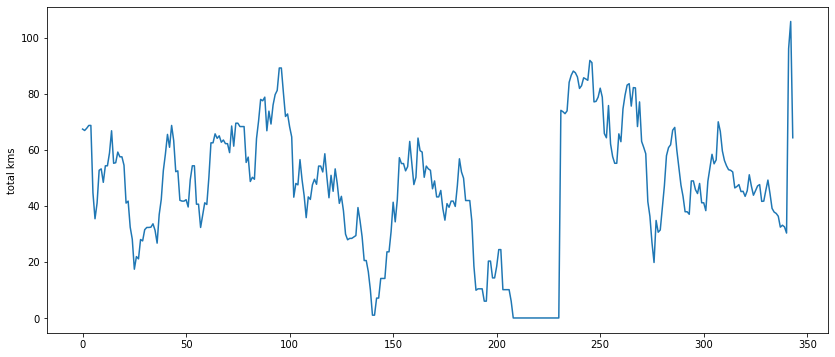

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (14,6))
sns.lineplot(data=df0['total kms'])

In [7]:
def indexIndividualData(id):
  df0 = df[df['Athlete ID'] == id]
  index1 = df0.index[0]
  indexLast = df0.index[-1]
  y = indexLast - len(df0[df0['injury']==0]) - len(df0[df0['injury']==1])
  df0 = df0.rename(index = lambda x: x - y - 1 if x > indexLast - len(df0[df0['injury']==1]) else x - index1)
  df0 = df0.sort_values(by = 'Date')
  return df0
def plotIndividualData(id, column):
  df0 = indexIndividualData(id)
  plt.figure(figsize = (14,6))
  sns.lineplot(data=df0[column])
 

We created a indexIndividualData function in contrast to injured, noninjured data. This will allow us to analyze data more clearly. 

total kms      110.078308
total kms.1    109.772017
total kms.2    106.549675
dtype: float64
nr. sessions      6.017354
nr. sessions.1    6.010846
nr. sessions.2    5.865510
dtype: float64
total kms      71.518745
total kms.1    71.278621
total kms.2    70.798683
dtype: float64
nr. sessions      5.557707
nr. sessions.1    5.557707
nr. sessions.2    5.525174
dtype: float64


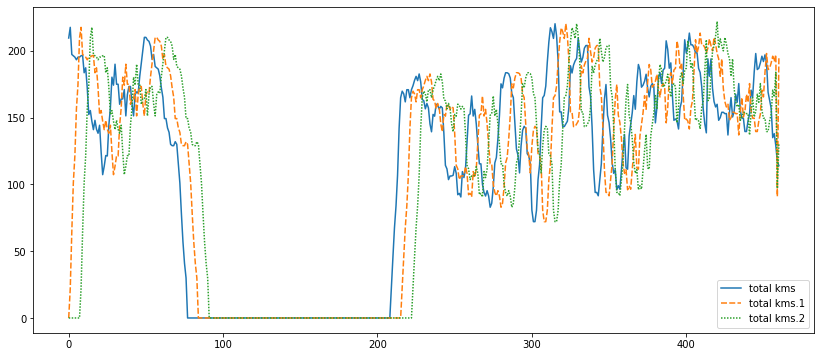

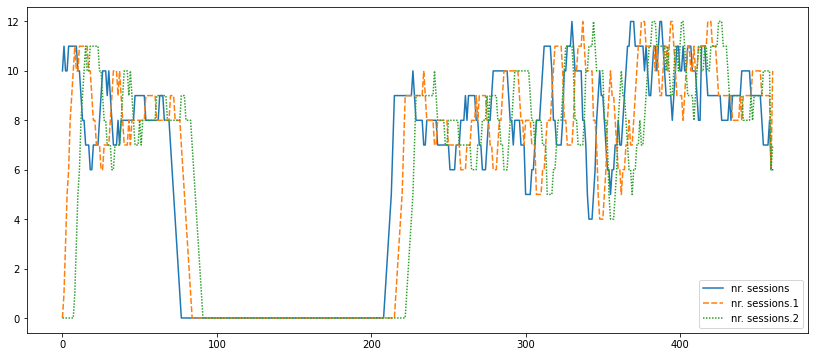

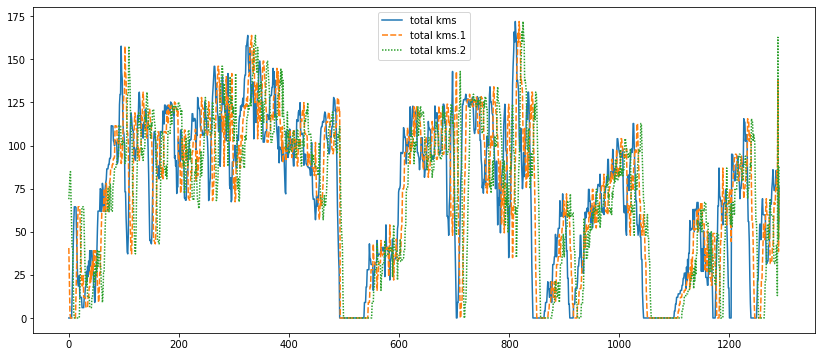

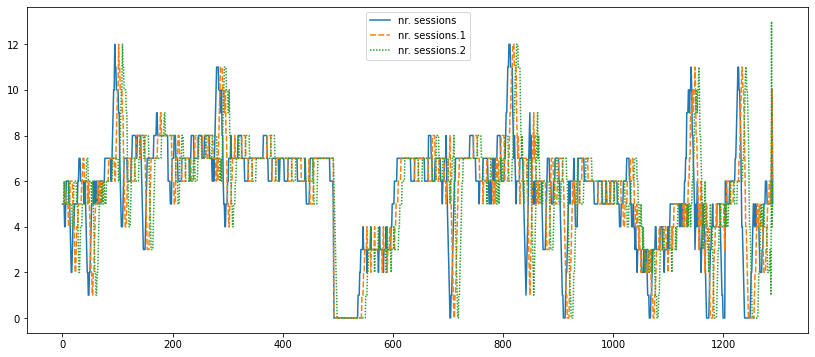

In [8]:
def dateInjurySubset(id, column1, column2, column3): 
  df0 = indexIndividualData(id)
  return df0[[column1,column2,column3]]



def plotIndividualDataDuoColumn(id, column1, column2, column3):
  df0 = dateInjurySubset(id,column1,column2,column3)
  plt.figure(figsize = (14,6))
  sns.lineplot(data=df0) 

print(dateInjurySubset(1,"total kms", "total kms.1","total kms.2").mean())
plotIndividualDataDuoColumn(1,"total kms", "total kms.1", "total kms.2")
print(dateInjurySubset(1,"nr. sessions", "nr. sessions.1","nr. sessions.2").mean())
plotIndividualDataDuoColumn(1,"nr. sessions", "nr. sessions.1","nr. sessions.2")
print(dateInjurySubset(2,"total kms", "total kms.1","total kms.2").mean())
plotIndividualDataDuoColumn(2,"total kms", "total kms.1", "total kms.2")
print(dateInjurySubset(2,"nr. sessions", "nr. sessions.1","nr. sessions.2").mean())
plotIndividualDataDuoColumn(2,"nr. sessions", "nr. sessions.1","nr. sessions.2") 

Since there does not seem to be any difference between the attributes and their ".1",".2" siblings, the attributes seem to be just noise. It could be justification to drop all the suffix attributes, as we are not sure what they contribute to the data  

In [9]:
dfQ2 = df[['Athlete ID', 'total km Z3-Z4-Z5-T1-T2', 'total km Z3-Z4-Z5-T1-T2.1', 'total km Z3-Z4-Z5-T1-T2.2', 'injury', 'nr. tough sessions (effort in Z5, T1 or T2)', 'nr. tough sessions (effort in Z5, T1 or T2).1', 'nr. tough sessions (effort in Z5, T1 or T2).2', 'total km Z5-T1-T2', 'total km Z5-T1-T2.1', 'total km Z5-T1-T2.2', 'total km Z3-4', 'total km Z3-4.1', 'total km Z3-4.2']]
dfArray = []
for i in df['Athlete ID'].unique():
  dfArray.append(indexIndividualData(i))

In [10]:
df0 = dfArray[1]
injury = df0[df0['injury'] == 1]
notInjured = df0[df0['injury'] == 0]
print("INJURED DATES ID 1")
for i in injury['Date']:
  print(i)
print("NOT INJURED DATES ID 1:\n")
for i in notInjured['Date']:
  print(i)

INJURED DATES ID 1
672
765
NOT INJURED DATES ID 1:

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
26

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


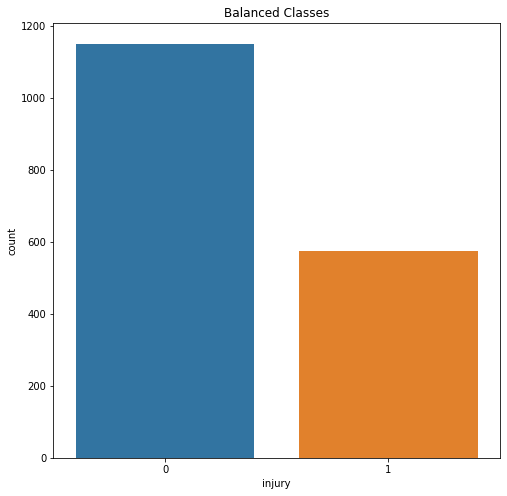

In [17]:
df1 = df0.sort_values(by = 'Athlete ID');

shuffled_df1 = df.sample(frac=1,random_state=4)

# Put all the fraud class in a separate dataset.
injury_df1 = shuffled_df1.loc[shuffled_df1['injury'] == 1]

#Randomly select 492 observations from the non-fraud (majority class)
non_injured_df1 = shuffled_df1.loc[shuffled_df1['injury'] == 0].sample(n=1150)

# Concatenate both dataframes again
normalized_df = pd.concat([injury_df1, non_injured_df1])

#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sns.countplot('injury', data=normalized_df)
plt.title('Balanced Classes')
plt.show()

In [21]:
y = normalized_df['injury']
X = normalized_df.drop('injury', axis=1)
X = normalized_df.drop('Athlete ID', axis=1)
X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.3, random_state = 0)

K = []
training = []
test = []
scores = {}
  
for k in range(2, 21):
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_train, y_train)
  
    training_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    K.append(k)
  
    training.append(training_score)
    test.append(test_score)
    scores[k] = [training_score, test_score]
    
for keys, values in scores.items():
    print(keys, ':', values)

2 : [0.831814415907208, 0.6525096525096525]
3 : [0.844241922120961, 0.6621621621621622]
4 : [0.7970173985086992, 0.6640926640926641]
5 : [0.792046396023198, 0.6891891891891891]
6 : [0.7613918806959403, 0.6718146718146718]
7 : [0.7655343827671914, 0.6833976833976834]
8 : [0.7655343827671914, 0.6756756756756757]
9 : [0.7555923777961889, 0.6737451737451737]
10 : [0.7531068765534383, 0.6911196911196911]
11 : [0.7431648715824358, 0.6853281853281853]
12 : [0.7315658657829329, 0.6756756756756757]
13 : [0.7274233637116818, 0.667953667953668]
14 : [0.7290803645401823, 0.6621621621621622]
15 : [0.728251864125932, 0.667953667953668]
16 : [0.7265948632974316, 0.6640926640926641]
17 : [0.7332228666114333, 0.6602316602316602]
18 : [0.7224523612261806, 0.666023166023166]
19 : [0.7207953603976802, 0.6563706563706564]
20 : [0.7133388566694283, 0.667953667953668]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


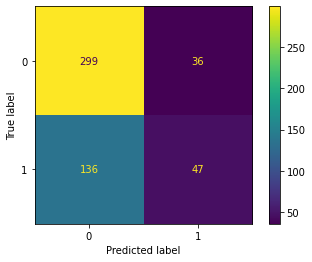

In [24]:
from sklearn.metrics import classification_report, plot_confusion_matrix 
# print(classification_report(df, df['injury']))
# print(classification_report(normalized_df1, normalized_df['injury']))
clf.fit(X_train, y_train)
plot_confusion_matrix(clf, X_test, y_test)